In [1]:
!pip install chronos-forecasting
import pandas as pd  # requires: pip install pandas
import numpy as np
import torch
from chronos import BaseChronosPipeline
from chronos import ChronosBoltPipeline
import matplotlib.pyplot as plt

In [3]:
#WQL FUNCTION (Sourced from chatGPT)


def quantile_loss(y_true, y_pred, alpha):
    """
    Computes quantile loss for a given quantile level alpha.
    
    Parameters:
    - y_true: True values (numpy array of shape (N,))
    - y_pred: Predicted quantile values (numpy array of shape (N,))
    - alpha: Quantile level (scalar)

    Returns:
    - Quantile loss (scalar)
    """
    diff = y_true - y_pred
    return np.maximum(alpha * diff, (alpha - 1) * diff).mean()

def weighted_quantile_loss(y_true, y_pred_quantiles, quantile_levels):
    """
    Computes the Weighted Quantile Loss (WQL) with the modified shape of predictions.

    Parameters:
    - y_true: True values (numpy array of shape (N,))
    - y_pred_quantiles: Predicted quantiles (numpy array of shape (K, N), where K is the number of quantiles)
    - quantile_levels: List or array of quantile levels (K,)

    Returns:
    - Weighted Quantile Loss (scalar)
    """
    assert y_pred_quantiles.shape[0] == len(quantile_levels), "Mismatch in quantile dimensions"

    # Compute WQL for each quantile
    wql_per_quantile = [
        (2 * quantile_loss(y_true, y_pred_quantiles[j, :], alpha)) / np.abs(y_true).sum()
        for j, alpha in enumerate(quantile_levels)
    ]
    
    # Final WQL (mean over quantiles)
    return np.mean(wql_per_quantile)

In [13]:
#MASE
def mase(y_true, y_pred, y_past, S):
    """
    Computes the Mean Absolute Scaled Error (MASE) while ignoring NaNs in the input arrays.

    Parameters:
    - y_true: Actual values (numpy array of shape (H,))
    - y_pred: Predicted values (numpy array of shape (H,))
    - y_past: Historical values (numpy array of shape (C,)) for computing seasonal naive MAE
    - S: Seasonality parameter (integer)

    Returns:
    - MASE score (scalar)
    """
    # Mask NaNs in y_true and corresponding elements in y_pred
    valid_mask = ~np.isnan(y_true)
    y_true_filtered = y_true[valid_mask]
    y_pred_filtered = y_pred[valid_mask]

    # Mask NaNs in y_past for seasonal naive MAE calculation
    past_valid_mask = ~np.isnan(y_past)
    y_past_filtered = y_past[past_valid_mask]

    # Ensure enough data remains after filtering
    if len(y_true_filtered) == 0 or len(y_past_filtered) <= S:
        return np.inf  # Avoid division by zero or invalid computation

    H = len(y_true_filtered)  # Adjusted prediction horizon
    C = len(y_past_filtered)  # Adjusted context length

    # Compute the numerator (MAE of forecast)
    numerator = np.sum(np.abs(y_pred_filtered - y_true_filtered)) / H

    # Compute the denominator (MAE of seasonal naive forecast)
    denominator = np.sum(np.abs(y_past_filtered[:-S] - y_past_filtered[S:])) / (C - S)

    return numerator / denominator if denominator != 0 else np.inf


# Experiment 1 (Baseline)

In [23]:
pipeline = ChronosBoltPipeline.from_pretrained(
    "amazon/chronos-bolt-tiny",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv(
    "https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv"
)

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# Chronos-Bolt models generate quantile forecasts, so forecast has shape
# [num_series, num_quantiles, prediction_length].
forecast = pipeline.predict(
    context=torch.tensor(df["#Passengers"].iloc[:-12]), prediction_length=12
)

### Test 1 (Ecological Datasets)

In [24]:
### RIU 
# RIU DATA
RIU = pd.read_csv('Data/RIU_cleaned.csv')
RIU

,Unnamed: 0,YearMonth,Total abundance
0,0,1999-01,1.240000e+05
1,1,1999-02,1.197500e+05
2,2,1999-03,1.983000e+05
3,3,1999-04,1.595075e+06
4,4,1999-05,1.199800e+06
...,...,...,...
308,308,2024-09,5.989750e+05
309,309,2024-10,1.103750e+05
310,310,2024-11,3.196667e+05
311,311,2024-12,3.283100e+06


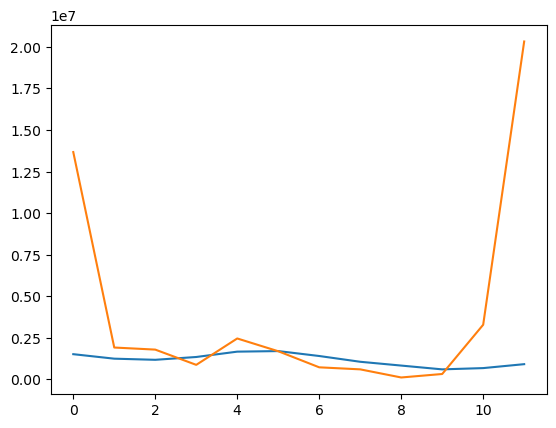

In [19]:
forecast = pipeline.predict_quantiles(
    context=torch.tensor(RIU["Total abundance"].iloc[:-12]), prediction_length=12
)
forecast = forecast[0].permute(0, 2, 1) 
plt.plot(forecast[0][4],label='forecast')
plt.plot(RIU["Total abundance"].iloc[-12:].to_numpy())

In [22]:
def metrics(y_true,y_pred,quantiles,y_past, s):
    wql = weighted_quantile_loss(y_true,y_pred,quantiles)
    mase_met = mase(y_true,y_pred,y_past,s)
    return wql, mase_met
def forecast_pipeline(pipeline):
    RIU = pd.read_csv('Data/RIU_cleaned.csv')
    forecast = pipeline.predict_quantiles(
        context=torch.tensor(RIU["Total abundance"].iloc[:-12]), prediction_length=12
    )
    forecast = forecast[0].permute(0, 2, 1) 
    quantiles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    RIU_wql, RIU_mase = metrics(RIU["Total abundance"].iloc[-12:].to_numpy(), forecast[0].numpy(), quantiles,RIU["Total abundance"].iloc[:-12].to_numpy(), 12)
    return RIU_wql, RIU_mase

forecast_pipeline(pipeline)
    

IndexError: boolean index did not match indexed array along dimension 0; dimension is 9 but corresponding boolean dimension is 12

In [20]:
quantiles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
RIU_wql = weighted_quantile_loss(RIU["Total abundance"].iloc[-12:].to_numpy(), forecast[0].numpy(), quantiles)
RIU_wql

0.06164571767516932

In [21]:
RIU_mase = mase(RIU["Total abundance"].iloc[-12:].to_numpy(), forecast[0][4].numpy(), RIU["Total abundance"].iloc[:-12].to_numpy(), 12)
RIU_mase

1.1386552328726978

In [16]:
### Lake Zurich
LZ = pd.read_csv('Data/LZ_data.csv').iloc[1:-31]
LZ

,time,Aphanizomenon flos-aquae,Asterionella formosa,Bosmina longirostris adult,Bosmina longirostris juvenile,Centrales,Ceratium hirundinella,Closterium aciculare,Cosmarium sp,Cyclopoida nauplia,...,Gymnodinium sp,Nitzschia sp,Pandorina morum,Phacotus lenticularis,Planktothrix rubescens,Rhodomonas sp,Staurastrum sp,Stephanodiscus sp,Tabellaria fenestrata,Ulnaria delicatissima var angustissima
1,1978-01,0.026471,0.128363,0.628794,0.381154,0.043904,0.092450,0.295599,0.182574,0.552631,...,0.116455,0.298190,0.000000,0.055546,0.098771,0.264326,0.181969,0.000000,0.038044,0.043784
2,1978-02,0.024028,0.292440,0.214502,0.094834,0.054953,0.000000,0.197066,0.000000,0.309576,...,0.265155,0.124354,0.000000,0.028283,0.089810,0.372288,0.081379,0.051647,0.064889,0.056822
3,1978-03,0.023532,0.400913,0.188684,0.067058,0.418967,0.065372,0.241355,0.000000,0.467537,...,0.374985,0.164505,0.081923,0.021380,0.087324,0.576430,0.162758,0.135557,0.025649,0.041416
4,1978-04,0.039616,0.114115,0.418685,0.301616,0.246669,0.130744,0.098533,0.000000,0.487138,...,0.190795,0.515232,0.115857,0.030235,0.217751,0.584662,0.181969,0.086079,0.016222,0.024605
5,1978-05,0.124877,0.567539,0.922277,0.212869,0.019634,0.000000,0.000000,0.341565,0.779625,...,0.077892,0.000000,0.306529,0.000000,0.038317,0.624562,0.244137,0.076991,0.073449,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2008-01,0.051306,0.099430,0.000000,0.000000,0.000000,0.480384,0.170664,0.365148,0.269650,...,0.137532,0.087932,0.271708,0.254768,0.498205,0.255615,0.115087,0.070704,0.032444,0.050224
362,2008-02,0.032440,0.037883,0.000000,0.000000,0.000000,0.375534,0.139347,0.288675,0.210479,...,0.143873,0.062177,0.259064,0.137729,0.456663,0.215838,0.081379,0.015074,0.019868,0.028411
363,2008-03,0.048166,0.105650,0.000000,0.000000,0.000000,0.369800,0.000000,0.223607,0.213460,...,0.148752,0.071796,0.295378,0.088796,0.631754,0.186113,0.000000,0.033707,0.039736,0.041416
364,2008-04,0.048708,0.096994,0.000000,0.000000,0.000000,0.092450,0.000000,0.182574,0.158047,...,0.194500,0.107694,0.245770,0.095013,0.707757,0.133491,0.081379,0.060296,0.028098,0.058571


In [ ]:
forecast = pipeline.predict(
    context=torch.tensor(RIU["Total abundance"].iloc[:-12]), prediction_length=12
)
plt.plot(forecast[0][4],label='forecast')
plt.plot(RIU["Total abundance"].iloc[-12:].to_numpy())